# ELE-32 - LAB 3 - LDPC (variante contínua)
---


# 1. Implemente um sistema que gera os valores LLR provenientes do canal quando transmitimos símbolos de uma modulação BPSK através de um canal Gaussiano
---

## Importações de bibliotecas
---

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from numba import njit
import networkx as nx

## Definição dos parâmetros do ruído
---

In [2]:
@njit
def calcular_variancia_ruido(Eb_N0_dB: float) -> float:
    """
    Calcula a variância do ruído com base na relação sinal-ruído Eb/N0 em decibéis.

    Args:
        Eb_N0_dB (float): A relação sinal-ruído Eb/N0 em decibéis.

    Returns:
        float: A variância do ruído.

    """
    # Converter a relação sinal-ruído Eb/N0 de decibéis para linear
    Eb_N0 = 10**(Eb_N0_dB / 10)

    # Calcular a densidade espectral de potência do ruído
    N0 = 1 / Eb_N0

    # Calcular a variância do ruído
    sigma2 = N0 / 2

    return sigma2

In [3]:
# Exemplo de uso da função calcular_variancia_ruido
variancia_ruido = calcular_variancia_ruido(5)
print(f"Variância do ruído: {variancia_ruido}")

Variância do ruído: 0.15811388300841897


## Geração de símbolos aleatórios
---

In [4]:
@njit
def gerar_simbolos_bpsk(num_bits: int) -> np.ndarray:
    """
    Gera símbolos BPSK aleatórios.

    Parâmetros:
    - num_bits: O número de bits a serem gerados.

    Retorna:
    - Uma sequência de símbolos BPSK aleatórios, representados por -1 e 1.
    """
    return np.random.choice(np.array([-1, 1]), num_bits)

In [5]:
# Exemplo de uso da função gerar_simbolos_bpsk
simbolos_bpsk = gerar_simbolos_bpsk(10)
print(f"Símbolos BPSK gerados: {simbolos_bpsk}")

Símbolos BPSK gerados: [ 1  1  1  1 -1  1  1 -1  1  1]


## Cálculo de r
---

In [6]:
@njit
def calcular_valor_recebido(simbolos: np.ndarray, Eb_N0_dB: float) -> np.ndarray:
    """
    Calcula o valor recebido adicionando ruído gaussiano aos símbolos transmitidos.

    Parâmetros:
    simbolos (array): Array contendo os símbolos transmitidos.
    Eb_N0_dB (float): Relação sinal-ruído em dB.

    Retorna:
    array: Array contendo os símbolos recebidos após a adição de ruído gaussiano.
    """
    sigma2 = calcular_variancia_ruido(Eb_N0_dB)
    sigma = np.sqrt(sigma2)
    ruido = sigma * np.random.randn(len(simbolos))
    r = simbolos + ruido
    return r

In [7]:
# Exemplo de uso da função calcular_valor_recebido
valores_recebidos = calcular_valor_recebido(simbolos_bpsk, 3)
print(f"Valores recebidos: {valores_recebidos}")

Valores recebidos: [ 1.51475962  1.53828166 -0.11773279  1.33658463 -0.99686494  1.97160999
  1.0930041  -1.65763872  1.92934944  1.47898633]


## Cálculo de LLR
---

In [8]:
@njit
def calcular_valores_llr(r: np.ndarray, sigma2: float) -> np.ndarray:
    """
    Calcula os valores do Log-Likelihood Ratio (LLR) para uma sequência de bits recebida.

    Args:
        r (float): A sequência de bits recebida.
        sigma2 (float): A variância do ruído.

    Returns:
        float: Os valores do LLR para cada bit da sequência recebida.
    """
    llr = 2 * r / sigma2
    return llr

In [9]:
# Exemplo de uso da função calcular_valores_llr
Lc = calcular_valores_llr(valores_recebidos, variancia_ruido)
print(f"Valores LLR: {Lc}")

Valores LLR: [ 19.16036202  19.45789497  -1.48921513  16.90660686 -12.60945492
  24.93911284  13.82552978 -20.9676556   24.40455456  18.70786173]


## Construção do LDPC (Lab 2)
---

### Definição de parâmetros

In [10]:
@njit
def set_params(N: int, dv: int, dc: int) -> tuple[int, int]:
    """
    Define os parâmetros do código LDPC.

    Args:
        N (int): O tamanho do código.
        dv (int): O grau do vetor de checagem.
        dc (int): O grau do vetor de informação.

    Returns:
        tuple[int, int]: Uma tupla contendo o tamanho da mensagem (K) e o tamanho do código (M).
    
    Raises:
        ValueError: Se N não for divisível por dc.
    """
    if (N  % dc != 0):
        raise ValueError("N must be divisible by dc")
    else:
        K = int(N / dc)
        M = int(K * dv)
        return (K, M)

In [11]:
# Exemplo de uso da função set_params
N = 10
dv = 3
dc = 5
K, M = set_params(N, dv, dc)
print(f"K: {K}; M: {M}")

K: 2; M: 6


### Geração da matriz LDPC

In [12]:
@njit
def generate_LDPC_matrix(N: int, dv: int, dc: int, K: int, M: int) -> np.ndarray:
    """
    Gera uma matriz LDPC de acordo com os parâmetros fornecidos.

    Parâmetros:
    - N (int): O número total de colunas da matriz.
    - dv (int): O grau do vértice variável.
    - dc (int): O grau do vértice de checagem.
    - K (int): O número de linhas da matriz antes da expansão.
    - M (int): O número de vezes que a matriz é expandida.

    Retorna:
    - H (ndarray): A matriz LDPC gerada.

    """
    H1 = np.zeros((K, N), dtype=np.int32)
    for i in range(len(H1)):
        H1[i][i * dc:(i + 1) * dc] = 1

    H = H1

    for _ in range(dv - 1):
        perm = np.random.permutation(N)
        H2 = H1[:, perm]
        H = np.concatenate((H, H2), axis=0)

    return H

In [ ]:
def is_peg_matrix(matrix):
    # Check if the matrix is binary
    if not np.array_equal(matrix, matrix.astype(bool)):
        return False

    # Check if the matrix is sparse
    if np.count_nonzero(matrix) / matrix.size > 0.5:
        return False

    # Check if the matrix is regular
    row_counts = np.count_nonzero(matrix, axis=1)
    if np.any(row_counts != row_counts[0]):
        return False
    col_counts = np.count_nonzero(matrix, axis=0)
    if np.any(col_counts != col_counts[0]):
        return False

    return True
def generate_LDPC_matrix_PEG(N: int, dv: int, dc: int, K: int, M: int) -> np.ndarray:
    H = np.zeros((M, N), dtype=np.int32)
    check_degrees = np.zeros(M, dtype=np.int32)
    symbol_degrees = np.zeros(N, dtype=np.int32)
    edges = []

    for j in range(N):
        for k in range(dv):
            if k == 0:
                # Find the check node with the lowest degree
                min_degree = np.min(check_degrees)
                min_degree_indices = np.where(check_degrees == min_degree)[0]
                ci = np.random.choice(min_degree_indices)
                edges.append((ci, j))
                check_degrees[ci] += 1
                symbol_degrees[j] += 1
            else:
                # Expand a tree from symbol node j
                tree = [j]
                for l in range(1, dc + 1):
                    next_level = []
                    for node in tree:
                        next_level.extend([edge[1] for edge in edges if edge[0] == node])
                    if len(next_level) == 0 or len(set(next_level)) < M:
                        break
                    tree = next_level

                # Find the check node with the lowest degree that is not in the tree
                min_degree = np.min(check_degrees[~np.isin(np.arange(M), tree)])
                min_degree_indices = np.where(check_degrees == min_degree)[0]
                ci = np.random.choice(min_degree_indices)
                edges.append((ci, j))
                check_degrees[ci] += 1
                symbol_degrees[j] += 1

    # Convert the edge list to a matrix
    for edge in edges:
        H[edge[0], edge[1]] = 1

    return H

In [13]:
# Exemplo de uso da função generate_LDPC_matrix
H = generate_LDPC_matrix(N, dv, dc, K, M)
print(f"Matriz LDPC gerada: \n{H}")

Matriz LDPC gerada: 
[[1 1 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 1 0 0 1 1 1 1]
 [1 1 1 0 1 1 0 0 0 0]
 [0 0 0 1 0 1 0 1 1 1]
 [1 1 1 0 1 0 1 0 0 0]]


In [14]:
H.shape

(6, 10)

In [20]:
H = generate_LDPC_matrix_PEG(N, dv, dc, K, M)
print(f"Matriz LDPC gerada: \n{H}")

Matriz LDPC gerada: 
[[0 1 0 1 1 0 0 1 1 0]
 [1 0 0 1 0 1 0 1 0 1]
 [0 1 1 0 0 1 1 0 0 1]
 [1 0 1 0 1 0 1 0 0 1]
 [0 1 1 0 0 1 1 0 1 0]
 [1 0 0 1 1 0 0 1 1 0]]


In [ ]:
print(is_peg_matrix(H))

In [18]:
H.shape

(6, 10)

## Simulação da comunicação
---

In [21]:
@njit
def inicializar_mensagens(H: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Inicializa as mensagens dos c-nodes para os v-nodes e dos v-nodes para os c-nodes.

    Args:
        H (numpy.ndarray): Matriz de verificação de paridade (H).

    Returns:
        tuple: Uma tupla contendo as mensagens dos c-nodes para os v-nodes (Le) e as mensagens dos v-nodes para os c-nodes (Lr).
    """
    num_cnodes, num_vnodes = H.shape
    Le = np.zeros((num_cnodes, num_vnodes))  # Mensagens dos c-nodes para os v-nodes
    Lr = np.zeros((num_cnodes, num_vnodes))  # Mensagens dos v-nodes para os c-nodes
    return Le, Lr

In [22]:
# Exemplo de uso da função inicializar_mensagens
Le, Lr = inicializar_mensagens(H)
print(f"Mensagens Le iniciais: {Le}")
print(f"Mensagens Lr iniciais: {Lr}")

Mensagens Le iniciais: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Mensagens Lr iniciais: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [23]:
@njit
def atualizar_mensagens_vnodes(Lr: np.ndarray, Lc: np.ndarray, Le: np.ndarray, H: np.ndarray) -> np.ndarray:
    """
    Atualiza as mensagens nos nós variáveis (v-nodes) de acordo com a matriz de paridade H.

    Parâmetros:
    - Lr: numpy.ndarray, matriz de mensagens nos nós de verificação (r-nodes)
    - Lc: numpy.ndarray, vetor de mensagens nos nós de checagem (c-nodes)
    - Le: numpy.ndarray, matriz de mensagens extrínsecas
    - H: numpy.ndarray, matriz de paridade

    Retorna:
    - Lr: numpy.ndarray, matriz de mensagens atualizadas nos nós de verificação (r-nodes)
    """
    num_cnodes, num_vnodes = H.shape
    for i in range(num_vnodes):
        for j in range(num_cnodes):
            if H[j, i] == 1:
                Lr[j, i] = Lc[i] + np.sum(Le[:, i]) - Le[j, i]
    return Lr

In [24]:
# Exemplo de uso da função atualizar_mensagens_vnodes
Lr = atualizar_mensagens_vnodes(Lr, Lc, Le, H)
print(f"Mensagens Lr atualizadas: {Lr}")

Mensagens Lr atualizadas: [[  0.          19.45789497   0.          16.90660686 -12.60945492
    0.           0.         -20.9676556   24.40455456   0.        ]
 [ 19.16036202   0.           0.          16.90660686   0.
   24.93911284   0.         -20.9676556    0.          18.70786173]
 [  0.          19.45789497  -1.48921513   0.           0.
   24.93911284  13.82552978   0.           0.          18.70786173]
 [ 19.16036202   0.          -1.48921513   0.         -12.60945492
    0.          13.82552978   0.           0.          18.70786173]
 [  0.          19.45789497  -1.48921513   0.           0.
   24.93911284  13.82552978   0.          24.40455456   0.        ]
 [ 19.16036202   0.           0.          16.90660686 -12.60945492
    0.           0.         -20.9676556   24.40455456   0.        ]]


In [25]:
@njit
def atualizar_mensagens_cnodes(Le: np.ndarray, Lr: np.ndarray, H: np.ndarray) -> np.ndarray:
    """
    Atualiza as mensagens nos nós de verificação (cnodes) de acordo com a matriz de paridade H.

    Args:
        Le (numpy.ndarray): Array bidimensional que representa as mensagens de entrada nos cnodes.
        Lr (numpy.ndarray): Array bidimensional que representa as mensagens de entrada nos vnodes.
        H (numpy.ndarray): Matriz de paridade que define as conexões entre cnodes e vnodes.

    Returns:
        numpy.ndarray: Array bidimensional com as mensagens atualizadas nos cnodes.
    """
    num_cnodes, num_vnodes = H.shape
    for j in range(num_cnodes):
        for i in range(num_vnodes):
            if H[j, i] == 1:
                # Calcula o produto dos sinais
                product_sign = 1
                min_value = np.inf
                for k in range(num_vnodes):
                    if k != i and H[j, k] == 1:
                        product_sign *= np.sign(Lr[j, k])
                        min_value = min(min_value, abs(Lr[j, k]))
                # Calcula a mensagem de saída usando a equação 11
                Le[j, i] = product_sign * min_value
    return Le

In [26]:
# Exemplo de uso da função atualizar_mensagens_cnodes
Le = atualizar_mensagens_cnodes(Le, Lr, H)
print(f"Mensagens Le atualizadas: {Le}")

Mensagens Le atualizadas: [[  0.          12.60945492   0.          12.60945492 -16.90660686
    0.           0.         -12.60945492  12.60945492   0.        ]
 [-16.90660686   0.           0.         -18.70786173   0.
  -16.90660686   0.          16.90660686   0.         -16.90660686]
 [  0.          -1.48921513  13.82552978   0.           0.
   -1.48921513  -1.48921513   0.           0.          -1.48921513]
 [  1.48921513   0.         -12.60945492   0.          -1.48921513
    0.           1.48921513   0.           0.           1.48921513]
 [  0.          -1.48921513  13.82552978   0.           0.
   -1.48921513  -1.48921513   0.          -1.48921513   0.        ]
 [ 12.60945492   0.           0.          12.60945492 -16.90660686
    0.           0.         -12.60945492  12.60945492   0.        ]]


## Definindo a decisão
---

In [27]:
@njit
def iteracao(Lc: np.ndarray, Le: np.ndarray, Lr: np.ndarray, H: np.ndarray) -> np.ndarray:
    """
    Realiza uma iteração do algoritmo de decodificação LDPC.

    Parâmetros:
    Lc (array): Array contendo as mensagens a priori dos c-nodes.
    Le (array): Array contendo as mensagens a priori dos v-nodes.
    Lr (array): Array contendo as mensagens dos v-nodes para os c-nodes.
    H (array): Matriz de verificação de paridade.

    Retorna:
    decision (array): Array contendo as decisões de bits após a iteração.
    """
    # Atualizar mensagens dos v-nodes
    Lr = atualizar_mensagens_vnodes(Lr, Lc, Le, H)
    
    # Atualizar mensagens dos c-nodes
    Le = atualizar_mensagens_cnodes(Le, Lr, H)
    
    # Critério de parada: verificar se todas as equações de paridade são satisfeitas
    decision = np.sign(Lc + np.sum(Le, axis=0))
    return decision

In [28]:
# Define a function for the parity check matrix
@njit
def syndrome_calc(H: np.array, x: np.array) -> np.array:
    s = np.zeros(H.shape[0], dtype = np.int32)

    for i in range(len(H)):
        s[i] = np.sum(H[i] * x) % 2
    
    return s

@njit
def parity_check(H: np.array, y: np.array) -> bool:
    x = y.copy()
    for i in range(len(y)):
        if x[i] > 0:
            x[i] = 0
        else:
            x[i] = 1

    column_length = H.shape[1]
    errors = np.ones(column_length, dtype = np.int32)

    s = syndrome_calc(H, x)
    
    for i in range(column_length):
        errors[i] = np.sum(H[:, i] * s)

    if np.sum(errors) == 0:
        return True
    else:
        return False

In [29]:
# Exemplo de uso da função iteracao
n = 0
n += 1
decision = iteracao(Lc, Le, Lr, H)
print(f"Iteração n: {n}")
print(f"Mensagens Le atualizada: {Le}")
print(f"Mensagens Lr atualizada: {Lr}")
np.all(np.mod(np.dot(H, decision), 2) == 0)

Iteração n: 1
Mensagens Le atualizada: [[  0.          10.80820005   0.          16.47946471 -10.80820005
    0.           0.         -10.80820005  10.80820005   0.        ]
 [-18.70786173   0.           0.         -18.70786173   0.
  -18.70786173   0.          18.70786173   0.         -21.96068258]
 [  0.          -0.27314027   3.29047      0.           0.
   -0.27314027  -0.27314027   0.           0.          -0.27314027]
 [ -0.31203974   0.          -0.31203974   0.           0.31203974
    0.          -0.31203974   0.           0.         -10.84709952]
 [  0.          -0.27314027   6.54329085   0.           0.
   -0.27314027  -0.27314027   0.          -0.27314027   0.        ]
 [ 10.80820005   0.           0.           3.74297029  -3.74297029
    0.           0.          -3.74297029   3.74297029   0.        ]]
Mensagens Lr atualizada: [[  0.          16.47946471   0.          10.80820005 -31.00527691
    0.           0.         -16.67050365  35.52479434   0.        ]
 [ 33.25903207

False

In [30]:
decision

array([ 1.,  1.,  1.,  1., -1.,  1.,  1., -1.,  1., -1.])

In [31]:
parity_check(H, decision)

False

# 2. Implemente o algoritmo de decodificação para códigos LDPC utilizando os valores LLR
---

In [32]:
@njit
def dot_product(H, decision):
    result = np.zeros(H.shape[0], dtype=H.dtype)
    for i in range(H.shape[0]):
        for j in range(H.shape[1]):
            result[i] += H[i, j] * decision[j]
    return result

@njit
def ldpc_decode(Lc: np.ndarray, Le: np.ndarray, Lr: np.ndarray, H: np.ndarray, max_iter: int = 100) -> np.ndarray:
    """
    Decodifica uma sequência de bits usando o algoritmo LDPC.

    Parâmetros:
    - Lc: array numpy de tamanho N, contendo as log-verossimilhanças dos bits recebidos.
    - H: array numpy de tamanho MxN, contendo a matriz de verificação de paridade LDPC.
    - max_iter: número máximo de iterações do algoritmo (padrão: 100).

    Retorna:
    - decoded_bits: array numpy de tamanho N, contendo os bits decodificados.

    """

    Le, Lr = inicializar_mensagens(H)
    n = 0

    for _ in range(max_iter):
        n += 1
        decision = iteracao(Lc, Le, Lr, H)
        if parity_check(H, decision):
            break
    
    print(f"{n} iterações")
    # Decisão final
    Lf = Lc + np.sum(Le, axis=0)
    decoded_bits = np.sign(Lf).astype(np.int32)
    return decoded_bits

In [33]:
# Exemplo de uso da função ldpc_decode
H = generate_LDPC_matrix(N, dv, dc, K, M)
bits_decodificados = ldpc_decode(Lc, Le, Lr, H)
print(f"Bits gerados:       {simbolos_bpsk}")
print(f"Bits decodificados: {bits_decodificados}")


36 iterações
Bits gerados:       [ 1  1  1  1 -1  1  1 -1  1  1]
Bits decodificados: [1 1 1 1 1 1 1 1 1 1]


In [34]:
# Teste
# Define a function for the parity check matrix
@njit
def parity_check_test(H: np.array, y: np.array) -> np.array:
    s = np.zeros(H.shape[0], dtype = np.int32)

    for i in range(len(H)):
        s[i] = np.sum(H[i] * y) % 2
    
    return s

# Define a function for the bit-flipping algorithm to decode the message
@njit
def bit_flipping(H: np.array, y: np.array, max_iter: int) -> np.array:
    iteration = 0
    x = y.copy()
    column_length = H.shape[1]
    errors = np.ones(column_length, dtype = np.int32)

    s = parity_check_test(H, x)

    while np.sum(s) != 0 and iteration <= max_iter:
        for i in range(column_length):
            errors[i] = np.sum(H[:, i] * s)

        for i in range(len(errors)):
            if errors[i] == np.max(errors):
                x[i] ^= 1    

        s = parity_check_test(H, x)
        iteration += 1

    return x

In [35]:
test = bits_decodificados.copy()
for i in range(len(test)):
        if test[i] > 0:
            test[i] = 0
        else:
            test[i] = 1
res = bit_flipping(H, test, 100)

for i in range(len(res)):
    if res[i] == 0:
        res[i] = 1
    else:
        res[i] = -1

res


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

# 3. Utilize as duas implementações acima para estimar o desempenho do código  LDPC
---

## Cálculo do Bit Error Rate (BER)
---

In [36]:
@njit
def calcular_ber(bits_originais: np.ndarray, bits_decodificados: np.ndarray) -> float:
    """
    Calcula a taxa de erro de bit (BER - Bit Error Rate) entre os bits originais e os bits decodificados.

    Parâmetros:
    - bits_originais: array de bits originais
    - bits_decodificados: array de bits decodificados

    Retorna:
    - ber: a taxa de erro de bit (BER)

    Exemplo de uso:
    >>> bits_originais = [0, 1, 0, 1, 0]
    >>> bits_decodificados = [0, 1, 1, 1, 0]
    >>> calcular_ber(bits_originais, bits_decodificados)
    0.2
    """
    erros = np.count_nonzero(bits_originais != bits_decodificados)
    ber = erros / len(bits_originais)
    return ber

In [37]:
# Exemplo de uso da função calcular_ber
ber = calcular_ber(simbolos_bpsk, bits_decodificados)
print(f"Ber: {ber}")

Ber: 0.2


## Simulação do desempenho do LDPC
---

In [38]:
@njit
def mean_2d_axis1(arr):
    return np.sum(arr, axis=1) / arr.shape[1]

@njit
def simular_desempenho_ldpc(H: np.ndarray, num_bits: int, Eb_N0_dB_range: np.ndarray, max_iter: int = 50) -> np.ndarray:
    ber_results = np.zeros((len(Eb_N0_dB_range), max_iter))
    
    for i in range(len(Eb_N0_dB_range)):
        for iter in range(max_iter):
            Eb_N0_dB = Eb_N0_dB_range[i]
            # Gerar símbolos BPSK
            simbolos = gerar_simbolos_bpsk(num_bits)
            
            # Calcular valores recebidos com ruído
            r = calcular_valor_recebido(simbolos, Eb_N0_dB)
            
            # Calcular valores LLR
            sigma2 = calcular_variancia_ruido(Eb_N0_dB)
            Lc = calcular_valores_llr(r, sigma2)
            
            # Decodificar
            bits_decodificados = ldpc_decode(Lc, Le, Lr, H, max_iter=max_iter)
            
            # Calcular BER
            ber = calcular_ber(simbolos, bits_decodificados)
            ber_results[i][iter] = ber
        
    return mean_2d_axis1(ber_results)

In [39]:
simular_desempenho_ldpc(H, N, np.arange(0, 10, 1), max_iter=50)

1 iterações
1 iterações
50 iterações
18 iterações
2 iterações
37 iterações
2 iterações
3 iterações
3 iterações
2 iterações
1 iterações
2 iterações
25 iterações
28 iterações
3 iterações
14 iterações
5 iterações
1 iterações
50 iterações
34 iterações
3 iterações
4 iterações
7 iterações
2 iterações
2 iterações
29 iterações
2 iterações
7 iterações
14 iterações
1 iterações
2 iterações
30 iterações
2 iterações
7 iterações
2 iterações
1 iterações
13 iterações
2 iterações
1 iterações
2 iterações
28 iterações
23 iterações
1 iterações
39 iterações
1 iterações
35 iterações
2 iterações
20 iterações
2 iterações
2 iterações
50 iterações
5 iterações
50 iterações
10 iterações
1 iterações
3 iterações
46 iterações
1 iterações
1 iterações
1 iterações
2 iterações
1 iterações
3 iterações
5 iterações
4 iterações
1 iterações
8 iterações
25 iterações
1 iterações
7 iterações
3 iterações
23 iterações
32 iterações
1 iterações
2 iterações
1 iterações
50 iterações
3 iterações
23 iterações
1 iterações
5 iterações
1 

array([0.264, 0.26 , 0.278, 0.256, 0.286, 0.27 , 0.27 , 0.274, 0.256,
       0.248])

In [45]:
# Definindo os parâmetros para simulação
num_bits = 999
Eb_N0_dB_range = np.arange(0, 5.5, 0.5)

In [46]:
# Gerando a matriz LDPC
N = num_bits
dv = 4
dc = 9
K, M = set_params(N, dv, dc)
H = generate_LDPC_matrix_PEG(N, dv, dc, K, M)

In [47]:
# Simulando o desempenho
ber_results = simular_desempenho_ldpc(H, num_bits, Eb_N0_dB_range, 1000)

1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 iterações
1000 itera

In [43]:
def plotar_ber(Eb_N0_dB_range, ber_results):
    plt.figure(figsize=(10, 6))
    plt.plot(Eb_N0_dB_range, ber_results, marker='o', linestyle='-', color='b')
    plt.yscale('log')
    plt.xlabel('Eb/N0 (dB)')
    plt.ylabel('Taxa de Erro de Bit (BER)')
    plt.title('Desempenho do Código LDPC')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

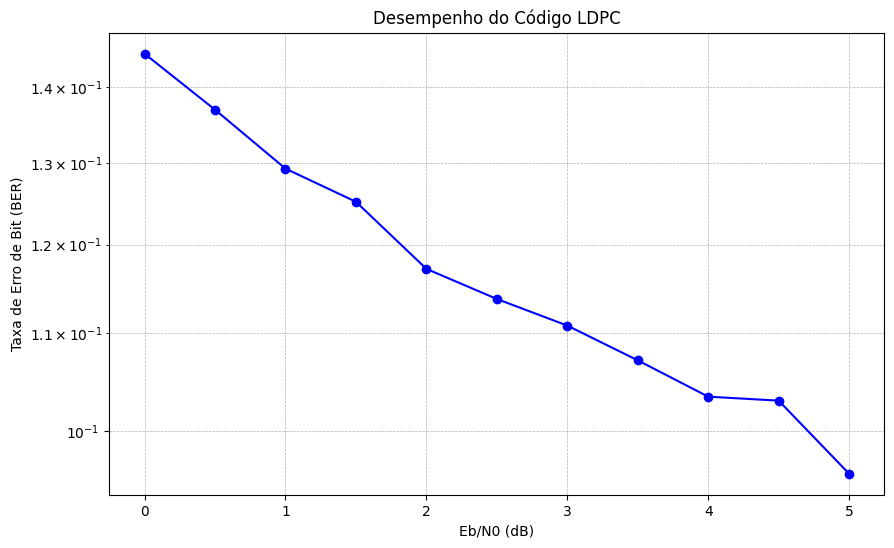

In [44]:
# Plotar o gráfico
plotar_ber(Eb_N0_dB_range, ber_results)

In [185]:
def encontrar_menor_eb_n0(ber_results, Eb_N0_dB_range, threshold=1e-4):
    for Eb_N0_dB, ber in zip(Eb_N0_dB_range, ber_results):
        if ber < threshold:
            return Eb_N0_dB
    return None

# Encontrar o menor valor de Eb/N0 para BER < 10^-4
menor_eb_n0 = encontrar_menor_eb_n0(ber_results, Eb_N0_dB_range)
print(f"Menor valor de Eb/N0 para BER < 10^-4: {menor_eb_n0} dB")

Menor valor de Eb/N0 para BER < 10^-4: None dB


In [ ]:
import csv

def gerar_grafo_csv(H, filename='grafo_ldpc.csv'):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        for row in H:
            indices = np.where(row == 1)[0]
            writer.writerow(indices)

# Exemplo de matriz H para N ≈ 1000
H = generate_LDPC_matrix(N, dv, dc, K, M)

# Gerar arquivo CSV
gerar_grafo_csv(H)